In [400]:
import matplotlib.pyplot as plt
import numpy as np
from gurobipy import Model, GRB
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools

class Genetic_Algorithm:
    def __init__(self, beta, img1, img2):
        self.beta = beta
        self.N = img1.shape[0]
        self.M = img2.shape[0]
        self.img1 = img1.flatten()
        self.img2 = img2.flatten()
        self.current_gamma, self.active_indices = self.initialise_omega()
        self.current_kantorovich_u = None
        self.current_kantorovich_v = None
        self.current_cost_vector = None
        self.cost = []
        self.time_rmp = []
        self.time_drmp = []
        self.time_child = []
        self.children_sampled = []

    def barycentric_distance(self,x, y):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        x = x / self.N
        y = y / self.M
        barycenter = x * 0.5 + y * 0.5
        barycenter = 0.5 * np.sum((x - barycenter) ** 2) + 0.5 * np.sum(
            (y - barycenter) ** 2)
        return barycenter

    def get_cost(self):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second
        indices_img1 = np.array(np.unravel_index(self.active_indices.transpose()[0], (self.N, self.N))).transpose()
        indices_img2 = np.array(np.unravel_index(self.active_indices.transpose()[1], (self.M, self.M))).transpose()
        cost_vector = np.array([self.barycentric_distance(i, j) for i,j in zip(indices_img1, indices_img2)])
        return cost_vector
    def get_single_cost(self, child):
        i = np.array(np.unravel_index(child[0], (self.N, self.N)))
        j = np.array(np.unravel_index(child[1], (self.M, self.M)))
        return self.barycentric_distance(i,j)

    def initialise_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        omega = [[0,0]]
        i, j = 0, 0
        b = np.array([self.img1[0], self.img2[0]])
        gamma = []
        current_gamma = [min(b[0], b[1])]
        while i < self.N**2-1 and j < self.M**2-1:
            gamma = min(b[0], b[1])
            b = b - gamma
            if np.argmin(b) == 0:
                i += 1
                b[0] += self.img1[i]
                omega.append([i, j])
                current_gamma.append(gamma)
            else:
                j += 1
                b[1] += self.img2[j]
                omega.append([i, j])
                current_gamma.append(gamma)
        while i < self.N**2-1:
            i += 1
            omega.append([i, j])
            current_gamma.append(0)
        while j < self.M**2-1:
            j += 1
            omega.append([i, j])
            current_gamma.append(0)

        return np.array(gamma), np.array(omega)
    def run(self, max_iter):
        for _ in tqdm(range(max_iter)):
            self.solve_RMP()
            self.solve_DRMP()
            gain = -1
            best_gain = -1
            best_child = None
            samples = 0
            start = time.time()
            non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            #create a generator with itertools with the cartesian product of the non zero indices and every pixel of the other image
            generator = itertools.product(non_zero_indices, np.arange(self.N**2), range(2))
            sample = 0
            #print how long is the generator

            for parent, half_child, image in generator:
                if image == 0:
                    child = np.array([half_child, parent[1]])
                else:
                    child = np.array([parent[0], half_child])
                gain = self.compute_gain(child)
                if gain > best_gain:
                    best_gain = gain
                    best_child = child
                if gain > 0:
                    break
                sample += 1
            if best_gain<=0:
                break
            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)
            self.active_indices = np.vstack((self.active_indices, best_child))
            self.current_cost_vector = np.append(self.current_cost_vector, self.get_single_cost(best_child))
            self.current_gamma = np.append(self.current_gamma, 0)
            if self.active_indices.shape[0] > self.beta*(self.N**2 + self.M**2):
                #delete first (beta-1)*(N^2 + M^2) 0 entries
                zero_indices = np.where(self.current_gamma == 0)[:beta]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)


    def get_child(self):
        #take a random index out of the non zero entries of the current gamma
        non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
        #create a generator with itertools with the cartesian product of the non zero indices and every pixel of the other image
        generator = itertools.product(non_zero_indices, np.arange(self.N**2), range(2))


        index = np.random.randint(0, non_zero_indices.shape[0])
        i, j = non_zero_indices[index]
        parent = np.random.randint(0, 2)
        if parent == 0:
            child = np.random.randint(0, self.N**2)
            return np.array([child, j])
        else:
            child = np.random.randint(0, self.M**2)
            return np.array([i, child])

    def compute_gain(self, child):
        return self.current_kantorovich_u[child[0]] + self.current_kantorovich_v[child[1]] - self.get_single_cost(child)


    def solve_RMP(self):

        if self.current_cost_vector is None:
            self.current_cost_vector = self.get_cost()
        mu = self.img1
        nu = self.img2
        model = Model()
        #suppress output
        model.setParam('OutputFlag', 0)
        gamma = model.addVars(len(self.current_cost_vector), vtype=GRB.CONTINUOUS, lb=0)
        model.setObjective(sum(
            self.current_cost_vector[i] * gamma[i] for i in range(len(self.current_cost_vector))), GRB.MINIMIZE)
        for indices in range(self.N**2):
            #find all the indices in self.active_indices that have the same first index
            gamma_indices = np.where(self.active_indices.transpose()[0] == indices)[0]
            model.addConstr(sum(gamma[i] for i in gamma_indices) == mu[indices])
        for indices in range(self.M**2):
            #find all the indices in self.active_indices that have the same second index
            gamma_indices = np.where(self.active_indices.transpose()[1] == indices)[0]
            model.addConstr(sum(gamma[i] for i in gamma_indices) == nu[indices])
        #before optimizing, print the model to make sure it is correct

        model.optimize()
        model.setAttr('Start', gamma, self.current_gamma)
        model.optimize()
        if model.status == GRB.Status.OPTIMAL:
            self.current_gamma = np.array(
                [gamma[i].x for i in range(len(self.current_cost_vector))])
            self.cost.append(model.objVal)
            self.time_rmp.append(model.Runtime)
            #print('The optimal objective is %g' % model.objVal)
        else:
            raise Exception(
                'The linear programming solver did not find a solution.')


    def solve_DRMP(self):
        mu = self.img1
        nu = self.img2
        model = Model()
        #suppress output
        model.setParam('OutputFlag', 0)
        u = model.addVars(self.N**2, vtype=GRB.CONTINUOUS)
        v = model.addVars(self.M**2, vtype=GRB.CONTINUOUS)
        model.setObjective(sum(mu[i]*u[i] for i in range(self.N)) + sum(nu[j]*v[j] for j in range(self.M)), GRB.MAXIMIZE)
        for index, set in enumerate(self.active_indices):
            i, j = set
            model.addConstr(u[i] + v[j] <= self.current_cost_vector[index])
        #warm start
        if self.current_kantorovich_u is not None:
            model.setAttr('Start', u, self.current_kantorovich_u)
            model.setAttr('Start', v, self.current_kantorovich_v)

        model.optimize()

        if model.status == GRB.Status.OPTIMAL:
            self.current_kantorovich_u = np.array([u[i].x for i in range(self.N**2)])
            self.current_kantorovich_v = np.array([v[j].x for j in range(self.M**2)])
            self.time_drmp.append(model.Runtime)
        else:
            raise Exception('The linear programming solver (dual) did not find a solution.')
    def get_mean(self, par):
        indices_x = np.unravel_index(self.active_indices.transpose()[0], (img1.shape[0], img1.shape[0]))
        indices_y = np.unravel_index(self.active_indices.transpose()[1], (img2.shape[0], img2.shape[0]))
        mean = (par * indices_x[0] + (1 - par) * indices_y[0]).astype('int'), (
                    par * indices_x[1] + (1 - par) * indices_y[1]).astype('int')
        #transform the mean back to a 1d index
        mean = np.ravel_multi_index(mean, (img1.shape[0], img1.shape[0]))
        #check how many coordinates of mean and indices_x are the same
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(img1.shape[0] ** 2, img2.shape[0] ** 2))
        return gamma.todense().transpose().dot(normalized_img1.flatten()).reshape(img1.shape[0], img1.shape[0])

    def plot(self):
        plt.close()
        fig, axs = plt.subplots(2, 6)
        axs[0][0].imshow(self.get_mean(1), cmap='gray')
        axs[0][1].imshow(self.get_mean(0.95), cmap='gray')
        axs[0][2].imshow(self.get_mean(0.9), cmap='gray')
        axs[0][3].imshow(self.get_mean(0.8), cmap='gray')
        axs[0][4].imshow(self.get_mean(0.7), cmap='gray')
        axs[0][5].imshow(self.get_mean(0.6), cmap='gray')
        axs[1][0].imshow(self.get_mean(0.5), cmap='gray')
        axs[1][1].imshow(self.get_mean(0.4), cmap='gray')
        axs[1][2].imshow(self.get_mean(0.3), cmap='gray')
        axs[1][3].imshow(self.get_mean(0.2), cmap='gray')
        axs[1][4].imshow(self.get_mean(0.1), cmap='gray')
        axs[1][5].imshow(self.get_mean(0), cmap='gray')
        plt.show()
    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

In [401]:
if __name__ == '__main__':
    lambda_parameter = 0.5
    #generate values between 0 and 1
    #load images
    path_img1 = "dolphin_64.jpg"
    path_img2 = "star_64.jpg"
    img1 = np.array(Image.open(path_img1).convert('L'))
    #switch black and white
    img2 = np.array(Image.open(path_img2).convert('L'))
    img_coordinates = np.array([[(i, j) for i in range(img1.shape[0])] for j in range(img2.shape[0])])

    img_coordinates = img_coordinates.reshape(img1.shape[0]*img2.shape[0], 2)
    normalized_img1 = img1 / 255
    normalized_img2 = img2 / 255
    normalized_img1 = 1 - normalized_img1
    normalized_img2 = 1 - normalized_img2
    normalized_img1 = normalized_img1 / np.sum(normalized_img1)
    normalized_img2 = normalized_img2 / np.sum(normalized_img2)
    beta = 3  # hyperparameter
    ga = Genetic_Algorithm(beta=beta, img1=normalized_img1, img2=normalized_img2)
    ga.run(max_iter=200)
    ga.plot()

 10%|█         | 20/200 [00:09<01:27,  2.06it/s]


KeyboardInterrupt: 

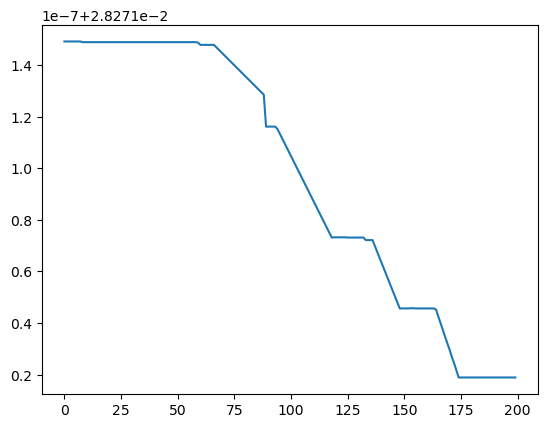

In [392]:
plt.plot(ga.cost)

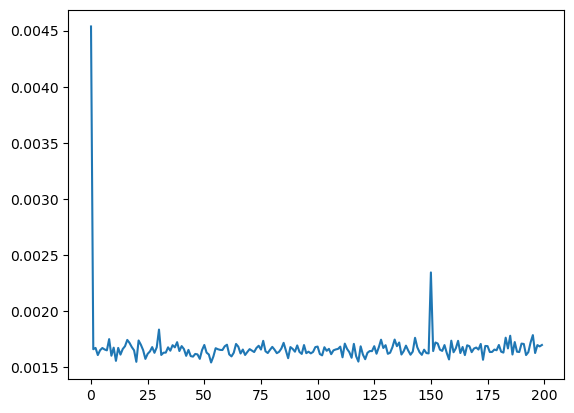

In [393]:
plt.plot(ga.time_rmp)

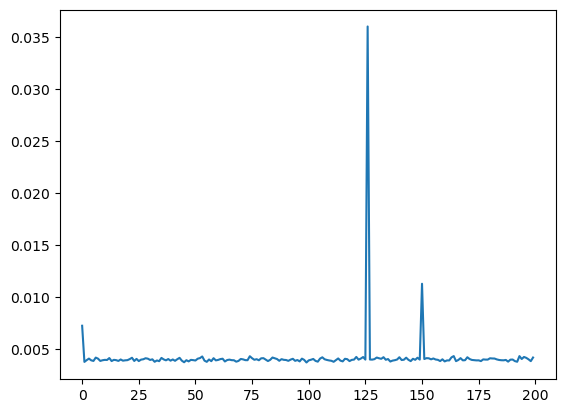

In [394]:
plt.plot(ga.time_drmp)

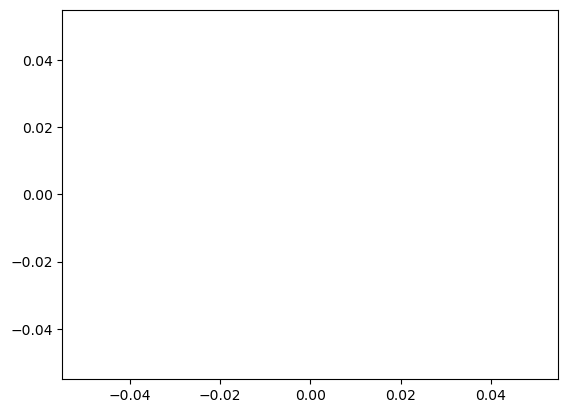

In [399]:
plt.plot(ga.time_child)

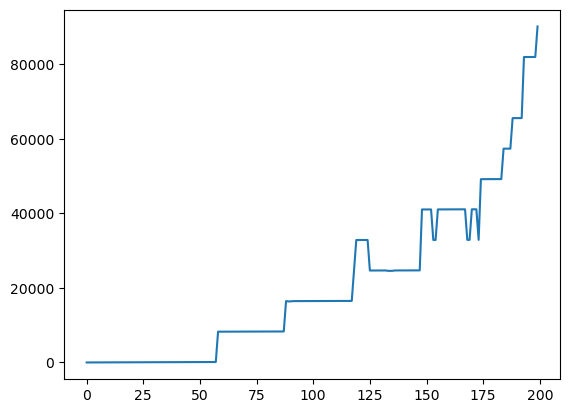

In [396]:
plt.plot(ga.children_sampled)